# Setups, Installations and Imports

This loss landscape analysis for MIMO is originally borrowed from the paper *Deep Ensembles: A Loss Landscape Perspective* by Fort et. al.
Code is available here: https://github.com/ayulockin/LossLandscape

more insights are take from "Visualizing the Loss Landscape of Neural Nets" at https://arxiv.org/pdf/1712.09913.pdf and "What can linear interpolation of neural network loss landscapes tell us?" at https://arxiv.org/pdf/2106.16004.pdf


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.applications import resnet50


In [ ]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

import io
import itertools
from sklearn.metrics import confusion_matrix

# Download and Prepare Dataset

#### MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

CLASS_NAMES = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


#### Dataloader

In [ ]:
# AUTO = tf.data.experimental.AUTOTUNE
# BATCH_SIZE = 128
# IMG_SHAPE = 28 # 28 for MNIST and 32 for CIFAR-10
# M = 3
# tf.random.set_seed(1)

# # For MNIST: 
# # reshape to fit to model. Add dim for the 1 color channel
# x_train = np.expand_dims(x_train, axis=3)
# y_train = np.expand_dims(y_train, axis=1)
# x_test = np.expand_dims(x_test, axis=3)
# y_test = np.expand_dims(y_test, axis=1)
# # Remove some datapoints to make sets divisable by 3 (so that all batches have size 3)
from sklearn.utils import shuffle
x_test, y_test = shuffle(x_test, y_test)
test_image_len=100
x_test = x_test[:test_image_len,:,:]
y_test = y_test[:test_image_len]

# trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# def preprocess_image(image, label):
#   img = tf.cast(image, tf.float32)
#   img = img/255.

#   return img, label

# trainloader_1 = (
#     trainloader
#     .shuffle(1024)
#     .map(preprocess_image, num_parallel_calls=AUTO)
#     .batch(3)
#     .prefetch(AUTO)
# )
# trainloader = (
#     trainloader_1
#     .shuffle(1024)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )

# testloader_1 = (
#     testloader
#     .map(preprocess_image, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE) # tried drop_remainder=True
#     .prefetch(AUTO)
# )

# testloader = (
#     testloader_1
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )


AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
IMG_SHAPE = 28 # 28 for MNIST and 32 for CIFAR-10
M = 3
tf.random.set_seed(1)

# For MNIST: 
# reshape to fit to model. Add dim for the 1 color channel
x_train = np.expand_dims(x_train, axis=3)
y_train = np.expand_dims(y_train, axis=1)
x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=1)
# Remove some datapoints to make sets divisable by 3 (so that all batches have size 3)
# x_test = x_test[:9999,:,:,:]
# y_test = y_test[:9999,:]

trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def preprocess_image(image, label):
  img = tf.cast(image, tf.float32)
  img = img/255.

  return img, label

# def tile_image(image, label):
#   print(image.shape)
#   # labels = tf.tile(tf.expand_dims(label, 1), [1, 3])
#   images = tf.tile(tf.expand_dims(image, 1), [1, 3, 1, 1, 1])
#   images = tf.squeeze(images, axis=0)
#   print(images.shape)
#   return images,label

def tile_image(image, label):
  print(label.shape)
  labels_tiled = tf.tile(tf.expand_dims(label, 2), [1, 3,1])
  images = tf.tile(tf.expand_dims(image, 1), [1, M, 1, 1, 1])
  images = tf.squeeze(images, axis=0)
  # label = tf.squeeze(labels_tiled, axis=0)
  return images,label

trainloader_1 = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(3)
    .prefetch(AUTO)
)
trainloader = (
    trainloader_1
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader_1 = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(1) # tried drop_remainder=True
    .prefetch(AUTO)
)

testloader = (
    testloader_1
    .map(tile_image)
    .batch(test_image_len)
    .prefetch(AUTO)
)

(None, 1)


# Visualize the landscape contour

In [ ]:
from tensorflow.keras import callbacks, layers

In [ ]:
# loss landscape implementation from:
# https://mathformachines.com/posts/visualizing-the-loss-landscape/

class RandomCoordinates(object):
    def __init__(self, origin):
        self.origin_ = origin
        self.v0_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin
        )
        self.v1_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin
        )

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]


def normalize_weights(weights, origin):
    return [
        w * np.linalg.norm(wc) / np.linalg.norm(w)
        for w, wc in zip(weights, origin)
    ]


class LossSurface(object):
    def __init__(self, model, inputs, outputs):
        self.model_ = model
        self.inputs_ = inputs
        self.outputs_ = outputs

    def compile(self, range, points, coords):
        a_grid = tf.linspace(-1.0, 1.0, num=points)** 3 * range
        b_grid = tf.linspace(-1.0, 1.0, num=points)** 3 * range
        loss_grid = np.empty([len(a_grid), len(b_grid)])
        m = tf.keras.metrics.SparseCategoricalAccuracy()
        m.reset_state()


        for i, a in enumerate(a_grid):
            for j, b in enumerate(b_grid):
                m.reset_state()
                self.model_.layers[3].set_weights((coords(a, b)[:2]))
                self.model_.layers[-1].set_weights(coords(a, b)[2:])

                logits= self.model_(self.inputs_)
                # compute loss
                labels_tiled = tf.tile(self.outputs_, [1, 3, 1])
                # print((np.shape(labels_tiled), np.shape(preds)))                
                log_likelihoods = -tf.keras.losses.sparse_categorical_crossentropy( labels_tiled, logits, from_logits=True)
                negative_log_likelihood = tf.reduce_mean( -tf.reduce_logsumexp(log_likelihoods, axis=[1])+ tf.math.log(float(3)))
                # print((negative_log_likelihood ,log_likelihoods) )

                ### compute accuracy
                # print(logits.shape)
                probs = tf.math.reduce_mean(logits, axis=1)  # marginalize
                pred_classes=np.argmax(probs,axis=1)
                m.update_state (self.outputs_, probs)
                accuracy = m.result().numpy() #+ 1e-5

                # acc=[]
                # for k in [0,1,2]:
                #   m.reset_state()
                #   m.update_state (self.outputs_, logits[:,k,:])
                #   acc.append(m.result().numpy()) #+ 1e-5

                # print(acc)
                plot= accuracy #negative_log_likelihood#acc 
                loss_grid[j, i] = plot
        self.model_.layers[3].set_weights(coords.origin_[:2] )
        self.model_.layers[-1].set_weights(coords.origin_[2:])
        self.a_grid_ = a_grid
        self.b_grid_ = b_grid
        self.loss_grid_ = loss_grid

    def plot(self, range=1.0, points=24, levels=50, ax=None, **kwargs):
        xs = self.a_grid_
        ys = self.b_grid_
        zs = self.loss_grid_
        if ax is None:
            _, ax = plt.subplots(**kwargs)
            ax.set_title("The Accuracy Surface")
            ax.set_aspect("equal")
        # Set Levels
        min_loss = zs.min()
        max_loss = zs.max()
        levels = tf.exp(
            tf.linspace(
                tf.math.log(min_loss), tf.math.log(max_loss), num=levels
            ))
        # levels = tf.linspace(min_loss, max_loss,num=levels)

        # Create Contour Plot
        CS = ax.contourf(
            xs,
            ys,
            zs,
            levels=levels,
            cmap="magma",
            linewidths=0.75,
            # norm=mpl.colors.LogNorm(vmin=min_loss, vmax=max_loss * 2.0),
        )
        # ax.clabel(CS, inline=True, fontsize=8, fmt="%1.2f")
        _.colorbar(CS)
        return ax

In [ ]:
# Load the model! - this directory contain folders of the model at each epoch
ROOT_PATH = '/content/drive/MyDrive/LossLandscape/'#'gdrive/My Drive/LossLandscape/'
## SmallCNN model checkpoint for each epoch(total 40 epochs)
MODEL_PATH = ROOT_PATH+'OK_TEST_MNIST_SmallCNN_CheckpointID_1/' #OK_TEST_
same_model_ckpts = os.listdir(MODEL_PATH)
print(len(same_model_ckpts))

40


In [ ]:
# sort the models
# https://stackoverflow.com/a/2669120/7636462
import re 

def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

same_model_ckpts = sorted_nicely(same_model_ckpts)
same_model_ckpts[:5]

['small_cnn_checkpoint_0.tf',
 'small_cnn_checkpoint_1.tf',
 'small_cnn_checkpoint_2.tf',
 'small_cnn_checkpoint_3.tf',
 'small_cnn_checkpoint_4.tf']

4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: UserWarning: linewidths is ignored by contourf


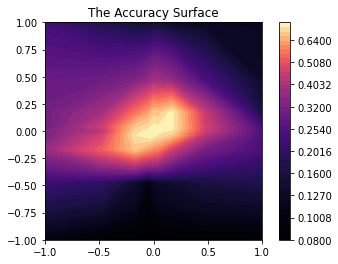

In [ ]:
# Create loss surface
model = tf.keras.models.load_model(MODEL_PATH+'/'+same_model_ckpts[20])
W=model.get_weights()[:2] + model.get_weights()[-2:]
model = tf.keras.models.load_model(MODEL_PATH+'/'+same_model_ckpts[-1])

print(len(W))
coords = RandomCoordinates(W)
for im,lb in testloader:
  imgs, labels=im, lb

loss_surface = LossSurface(model, imgs, labels)
loss_surface.compile(range=1, points=10, coords=coords)

# Look at loss surface
loss_surface.plot()

# plot_training_path(pcoords, training_path1, ax)

In [ ]:
# ax=loss_surface.plot(dpi=150)
# coords = RandomCoordinates(training_path3[-1] )
# plot_training_path(coords, training_path1, ax)
# plot_training_path(coords, training_path2, ax)
# plot_training_path(coords, training_path3, ax)

In [ ]:
from sklearn.decomposition import PCA

# Some utility functions to reshape network weights
def vectorize_weights_(weights):
    vec = [w.flatten() for w in weights]
    vec = np.hstack(vec)
    return vec


def vectorize_weight_list_(weight_list):
    vec_list = []
    for weights in weight_list:
        vec_list.append(vectorize_weights_(weights))
    weight_matrix = np.column_stack(vec_list)
    return weight_matrix


def shape_weight_matrix_like_(weight_matrix, example):
    weight_vecs = np.hsplit(weight_matrix, weight_matrix.shape[1])
    sizes = [v.size for v in example]
    shapes = [v.shape for v in example]
    weight_list = []
    for net_weights in weight_vecs:
        vs = np.split(net_weights, np.cumsum(sizes))[:-1]
        vs = [v.reshape(s) for v, s in zip(vs, shapes)]
        weight_list.append(vs)
    return weight_list


def get_path_components_(training_path, n_components=2):
    # Vectorize network weights
    weight_matrix = vectorize_weight_list_(training_path)
    # Create components
    pca = PCA(n_components=2, whiten=True)
    components = pca.fit_transform(weight_matrix)
    # Reshape to fit network
    example = training_path[0]
    weight_list = shape_weight_matrix_like_(components, example)
    return pca, weight_list


class PCACoordinates(object):
    def __init__(self, training_path):
        origin = training_path[0]
        self.pca_, self.components = get_path_components_(training_path)
        self.set_origin(origin)

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]

    def set_origin(self, origin, renorm=True):
        self.origin_ = origin
        if renorm:
            self.v0_ = normalize_weights(self.components[0], origin)
            self.v1_ = normalize_weights(self.components[1], origin)

In [ ]:
trained_models=[tf.keras.models.load_model(MODEL_PATH+'/'+model) for model in same_model_ckpts]

In [ ]:
from copy import copy
training_path = [training_p.get_weights()[:2]+ training_p.get_weights()[-2:] for training_p in trained_models]
training_path1= [training_p.get_weights()[:1]+ training_p.get_weights()[-2:] for training_p in trained_models]
training_path2= [training_p.get_weights()[:1]+ training_p.get_weights()[-2:] for training_p in trained_models]
training_path3= [training_p.get_weights()[:1]+ training_p.get_weights()[-2:] for training_p in trained_models]

for i in range(len(training_path1)):
  for j in range(len(training_path1[i])):
      weight_to_spit=training_path1[i][j]
      splitted_weights=np.hsplit(weight_to_spit, indices_or_sections =3)
      training_path1[i][j]= splitted_weights[0]
      training_path2[i][j]= splitted_weights[1]
      training_path3[i][j]= splitted_weights[2]
sub1=[] 
sub2=[] 
sub3=[]  
training_path_separate=[]    
for weights in training_path:
      nn1=[ np.split(weights[0], indices_or_sections =3, axis=2)[0],
        weights[1],
        np.split(weights[2], indices_or_sections =3, axis=1)[0],
        np.split(weights[3], indices_or_sections =3, axis=0)[0],
        ]
      sub1.append(nn1)

      nn2=[
        np.split(weights[0], indices_or_sections =3, axis=2)[1],
        weights[1],
        np.split(weights[2], indices_or_sections =3, axis=1)[1],
        np.split(weights[3], indices_or_sections =3, axis=0)[1],
        ]
      sub2.append(nn2)
      nn3=[
        np.split(weights[0], indices_or_sections =3, axis=2)[2],
        weights[1],
        np.split(weights[2], indices_or_sections =3, axis=1)[2],
        np.split(weights[3], indices_or_sections =3, axis=0)[2],
        ]
      sub3.append(nn3)

      training_path_separate.append(nn1)
      training_path_separate.append(nn2)
      training_path_separate.append(nn3)

      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: UserWarning: linewidths is ignored by contourf


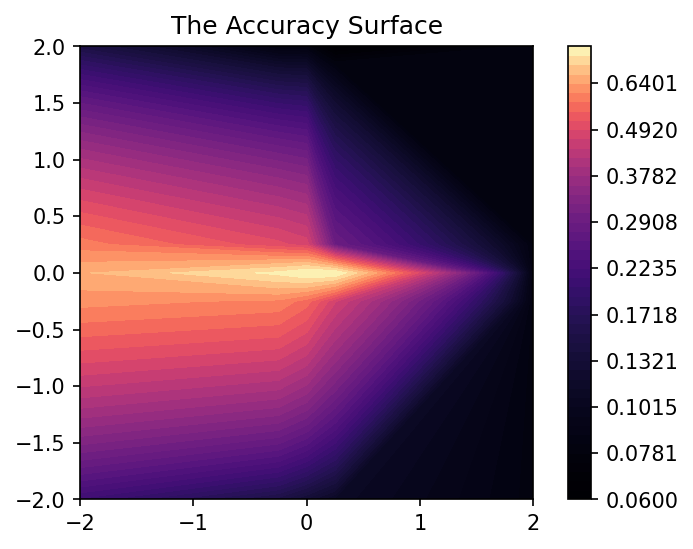

In [ ]:


coords = PCACoordinates(training_path)
model = tf.keras.models.load_model(MODEL_PATH+'/'+same_model_ckpts[-1])

for im,lb in testloader:
  imgs, labels=im, lb
loss_surface = LossSurface(model, imgs, labels)

loss_surface.compile(points=5, coords=coords, range=2)
# Look at loss surface
ax =loss_surface.plot(dpi=150)

In [ ]:
def weights_to_coordinates(coords, training_path):
    """Project the training path onto the first two principal components
using the pseudoinverse."""
    components = [coords.v0_, coords.v1_]
    comp_matrix = vectorize_weight_list_(components)
    # the pseudoinverse
    comp_matrix_i = np.linalg.pinv(comp_matrix)
    # the origin vector
    w_c = vectorize_weights_(training_path[0])
    # center the weights on the training path and project onto components
    coord_path = np.array(
        [
            comp_matrix_i @ (vectorize_weights_(weights) - w_c)
            for weights in training_path
        ]
    )
    return coord_path


def plot_training_path(coords, training_path, ax=None, end=None, **kwargs):
    path = weights_to_coordinates(coords, training_path)
    if ax is None:
        fig, ax = plt.subplots(**kwargs)
    colors = range(path.shape[0])
    end = path.shape[0] if end is None else end
    norm = plt.Normalize(0, end)
    ax.scatter(
        path[:, 0], path[:, 1], s=4, c=colors, cmap="ocean", norm=norm,
    )
    return ax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: UserWarning: linewidths is ignored by contourf


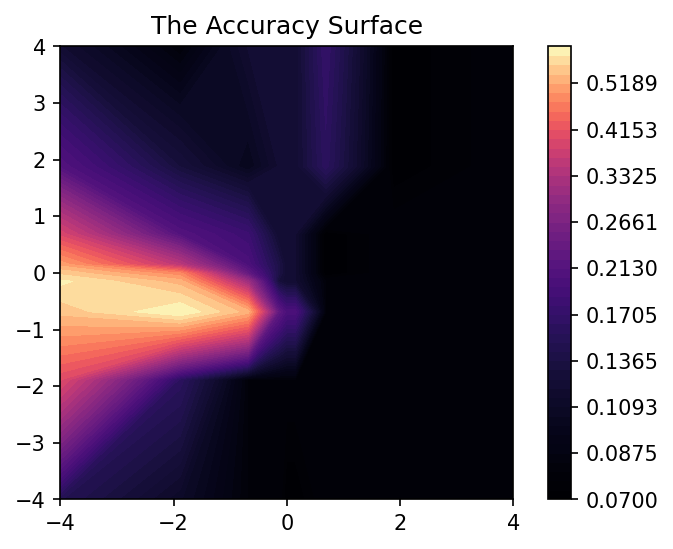

In [ ]:
pcoords = PCACoordinates(training_path)
loss_surface = LossSurface(model, imgs, labels)
loss_surface.compile(points=10, coords=pcoords, range=4)
ax = loss_surface.plot(dpi=150)
# plot_training_path(pcoords, training_path1, ax)

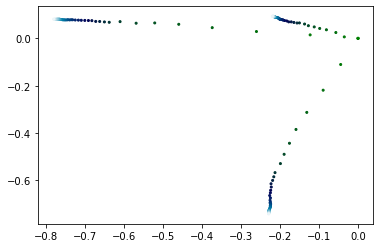

In [ ]:
# ax = loss_surface.plot(dpi=150)
fig, ax = plt.subplots()
pcoords = PCACoordinates(training_path_separate)
plot_training_path(pcoords, sub1, ax)
plot_training_path(pcoords, sub2, ax)
plot_training_path(pcoords, sub3, ax)